In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import r2_score

TypeError: unhashable type: 'list'

In [ ]:
dataframe = pd.read_csv('car_price_prediction.csv', na_values=['-'])
dataframe

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399.0,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018.0,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,NaN,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862.0,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446.0,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19232,45798355,8467,NaN,MERCEDES-BENZ,CLK 200,1999,Coupe,Yes,CNG,2.0 Turbo,300000 km,4.0,Manual,Rear,02-Mar,Left wheel,Silver,5
19233,45778856,15681,831.0,HYUNDAI,Sonata,2011,Sedan,Yes,Petrol,2.4,161600 km,4.0,Tiptronic,Front,04-May,Left wheel,Red,8
19234,45804997,26108,836.0,HYUNDAI,Tucson,2010,Jeep,Yes,Diesel,2,116365 km,4.0,Automatic,Front,04-May,Left wheel,Grey,4
19235,45793526,5331,1288.0,CHEVROLET,Captiva,2007,Jeep,Yes,Diesel,2,51258 km,4.0,Automatic,Front,04-May,Left wheel,Black,4


In [ ]:
dataframe = dataframe.drop(['ID', 'Levy', 'Color', 'Model'], axis=1)
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             19237 non-null  int64  
 1   Manufacturer      19237 non-null  object 
 2   Prod. year        19237 non-null  int64  
 3   Category          19237 non-null  object 
 4   Leather interior  19237 non-null  object 
 5   Fuel type         19237 non-null  object 
 6   Engine volume     19237 non-null  object 
 7   Mileage           19237 non-null  object 
 8   Cylinders         19237 non-null  float64
 9   Gear box type     19237 non-null  object 
 10  Drive wheels      19237 non-null  object 
 11  Doors             19237 non-null  object 
 12  Wheel             19237 non-null  object 
 13  Airbags           19237 non-null  int64  
dtypes: float64(1), int64(3), object(10)
memory usage: 2.1+ MB


Также удалим дубликаты

In [ ]:
dataframe.duplicated().sum()

3542

In [ ]:
dataframe = dataframe.drop_duplicates()

Преобразуем типы некоторых колонок

In [ ]:
dataframe['Mileage'] = dataframe['Mileage'].apply(lambda x: x.split(' ')[0])
dataframe['Mileage'] = dataframe['Mileage'].astype('int64')

dataframe['Cylinders'] = dataframe['Cylinders'].astype('int64')

dataframe['Leather interior'] = dataframe['Leather interior'].apply(lambda x: 1 if x == 'Yes' else 0)

dataframe['Turbo'] = dataframe['Engine volume'].apply(lambda x: 1 if len(x.split(' ')) == 2 else 0)

dataframe['Engine volume'] = dataframe['Engine volume'].apply(lambda x: x.split(' ')[0])
dataframe['Engine volume'] = dataframe['Engine volume'].astype('float')
dataframe['Price'] = dataframe['Price'].astype('float')

In [ ]:
dataframe.head(3)

,Price,Manufacturer,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Airbags,Turbo
0,13328.0,LEXUS,2010,Jeep,1,Hybrid,3.5,186005,6,Automatic,4x4,04-May,Left wheel,12,0
1,16621.0,CHEVROLET,2011,Jeep,0,Petrol,3.0,192000,6,Tiptronic,4x4,04-May,Left wheel,8,0
2,8467.0,HONDA,2006,Hatchback,0,Petrol,1.3,200000,4,Variator,Front,04-May,Right-hand drive,2,0


In [ ]:
dataframe.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,Price,Prod. year,Leather interior,Engine volume,Mileage,Cylinders,Airbags,Turbo
count,15695.00000,15695.00000,15695.00000,15695.00000,15695.00000,15695.00000,15695.00000,15695.00000
mean,20280.91500,2010.52176,0.67162,2.21272,1839769.35183,4.48289,6.54132,0.12010
std,210835.48043,6.01046,0.46964,0.80581,53583561.14726,1.13331,4.06725,0.32509
min,1.00000,1939.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000
25%,7527.00000,2008.00000,0.00000,1.70000,66756.50000,4.00000,4.00000,0.00000
50%,14269.00000,2012.00000,1.00000,2.00000,121000.00000,4.00000,6.00000,0.00000
75%,23376.50000,2014.00000,1.00000,2.50000,180000.00000,4.00000,12.00000,0.00000
max,26307500.00000,2020.00000,1.00000,20.00000,2147483647.00000,16.00000,16.00000,1.00000


Минимальная цена автомобиля равна 1 доллару, исходя из логики ограничим нижнюю границу до 1000 долларов, а также мощность двигателя должна быть больше нуля

In [ ]:
dataframe = dataframe[dataframe['Price'] >= 1000]
dataframe = dataframe[dataframe['Engine volume'] > 0]
dataframe = dataframe[dataframe['Mileage'] < 500000]
dataframe = dataframe[dataframe['Prod. year'] > 1980]

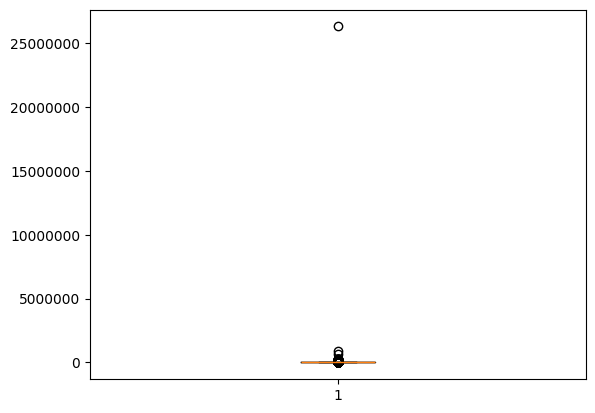

In [ ]:
fig, ax = plt.subplots()
plt.boxplot(dataframe['Price'])
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.show()

График показывает аномально большие выбросы, удалим их по формуле

In [ ]:
q_25 = dataframe['Price'].quantile(q=.25)
q_75 = dataframe['Price'].quantile(q=.75)
interquartile_range = q_75 - q_25   
dataframe = dataframe[dataframe['Price'] < q_75 + 1.5 * interquartile_range]

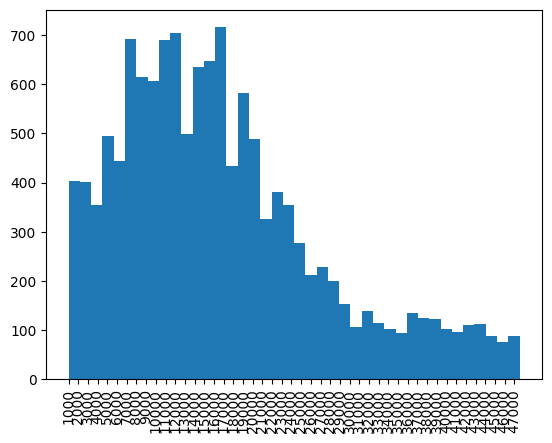

In [ ]:
plt.hist(dataframe['Price'], 40)
plt.xticks(np.arange(dataframe['Price'].min(), dataframe['Price'].max(), 1000), rotation=90)
plt.show()

In [ ]:
categorical_data = pd.concat((dataframe[['Engine volume', 'Cylinders', 'Airbags']].astype(str), dataframe.select_dtypes(include=['object'])), axis=1)
data = pd.concat((dataframe[['Price', 'Prod. year', 'Leather interior', 'Turbo']], pd.get_dummies(categorical_data, dtype='int')), axis=1)
data

,Price,Prod. year,Leather interior,Turbo,Engine volume_0.1,Engine volume_0.2,Engine volume_0.3,Engine volume_0.4,Engine volume_0.5,Engine volume_0.6,...,Gear box type_Tiptronic,Gear box type_Variator,Drive wheels_4x4,Drive wheels_Front,Drive wheels_Rear,Doors_02-Mar,Doors_04-May,Doors_>5,Wheel_Left wheel,Wheel_Right-hand drive
0,13328.0,2010,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
1,16621.0,2011,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,1,0,1,0
2,8467.0,2006,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,1
3,3607.0,2011,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
4,11726.0,2014,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19225,8781.0,2007,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0
19226,7840.0,2003,1,0,0,0,0,0,0,0,...,1,0,0,0,1,0,1,0,0,1
19232,8467.0,1999,1,1,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,1,0
19233,15681.0,2011,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,1,0


# Обучение моделей

In [ ]:
y = data.pop('Price')
X = data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
scaler =  StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [ ]:
X_train_sc.shape

(9865, 185)

Чтобы избежать переобучения сети, нужно указать количество слоев и нейронов в несколько раз меньше, чем 

In [ ]:
sgd_mse_model = keras.models.Sequential([
    keras.layers.Input(shape=(185, )),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(1, activation='relu'),
])

In [ ]:
sgd_mse_model.compile(optimizer='sgd', loss='mse', metrics=['r2_score'])
sgd_mse_model_h = sgd_mse_model.fit(X_train_sc, y_train, validation_data=[X_test_sc, y_test], epochs=40)

Epoch 1/40
309/309 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 27869931114594304.0000 - r2_score: -251790880.0000 - val_loss: 413661312.0000 - val_r2_score: -2.5448
Epoch 2/40
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 385915360.0000 - r2_score: -2.5277 - val_loss: 413661312.0000 - val_r2_score: -2.5448
Epoch 3/40
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 389869600.0000 - r2_score: -2.4771 - val_loss: 413661312.0000 - val_r2_score: -2.5448
Epoch 4/40
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 393189472.0000 - r2_score: -2.5578 - val_loss: 413661312.0000 - val_r2_score: -2.5448
Epoch 5/40
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 386388768.0000 - r2_score: -2.4838 - val_loss: 413661312.0000 - val_r2_score: -2.5448
Epoch 6/40
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 383167872.0000 - r2_score: -2.5808 - val_loss: 413661312.0000 - val_r2_score: -2.5448
Epoch 7/40
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 385591904.0000 - r2_score: -2.5274 - val_loss: 4

In [ ]:
r2_score(y_test, sgd_mse_model.predict(X_test_sc))

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


-2.544844751638503

In [ ]:
adam_mae_model = keras.models.Sequential([
    keras.layers.Input(shape=(185, )),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(1, activation='relu'),
])

In [ ]:
adam_mae_model.compile(optimizer='adam', loss='mae', metrics=['r2_score'])
adam_mae_model_h = adam_mae_model.fit(X_train_sc, y_train, validation_data=[X_test_sc, y_test], epochs=40)

Epoch 1/40
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 16722.0527 - r2_score: -2.5082 - val_loss: 16149.6338 - val_r2_score: -2.2246
Epoch 2/40
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 14357.1328 - r2_score: -1.8271 - val_loss: 9750.7344 - val_r2_score: -0.5490
Epoch 3/40
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8454.9111 - r2_score: -0.2574 - val_loss: 6940.8008 - val_r2_score: 0.1802
Epoch 4/40
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6737.8711 - r2_score: 0.1980 - val_loss: 6436.4639 - val_r2_score: 0.3059
Epoch 5/40
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6330.7192 - r2_score: 0.3193 - val_loss: 6183.2139 - val_r2_score: 0.3610
Epoch 6/40
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6152.8789 - r2_score: 0.3700 - val_loss: 6013.5259 - val_r2_score: 0.3980
Epoch 7/40
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5834.3101 - r2_score: 0.4077 - val_loss: 5888.9150 - val_r2_score: 0.4230
Epoch 8/40
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - 

In [ ]:
r2_score(y_test, adam_mae_model.predict(X_test_sc))

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


0.6674219956407735

In [ ]:
adam_mse_model = keras.models.Sequential([
    keras.layers.Input(shape=(185, )),
    keras.layers.Dense(500, activation='relu'),
    keras.layers.Dense(150, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(1, activation='relu'),
])

In [ ]:
adam_mse_model.compile(optimizer='adam', loss='mse', metrics=['r2_score'])
adam_mse_model_h = adam_mse_model.fit(X_train_sc, y_train, validation_data=[X_test_sc, y_test], epochs=40)

Epoch 1/40
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 269634080.0000 - r2_score: -1.3754 - val_loss: 60259940.0000 - val_r2_score: 0.4836
Epoch 2/40
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 56576968.0000 - r2_score: 0.4897 - val_loss: 52153320.0000 - val_r2_score: 0.5531
Epoch 3/40
309/309 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 47959760.0000 - r2_score: 0.5733 - val_loss: 47340632.0000 - val_r2_score: 0.5943
Epoch 4/40
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 42961948.0000 - r2_score: 0.6205 - val_loss: 43109324.0000 - val_r2_score: 0.6306
Epoch 5/40
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 37283696.0000 - r2_score: 0.6589 - val_loss: 41143116.0000 - val_r2_score: 0.6474
Epoch 6/40
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 36572748.0000 - r2_score: 0.6700 - val_loss: 40462576.0000 - val_r2_score: 0.6533
Epoch 7/40
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 34403580.0000 - r2_score: 0.6909 - val_loss: 39820724.0000 - val_r2_score: 0.6588
Epoc

In [ ]:
r2_score(y_test, adam_mse_model.predict(X_test_sc))

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


0.683961206065395

In [ ]:
rmsprop_mse_model = keras.models.Sequential([
    keras.layers.Input(shape=(185, )),
    keras.layers.Dense(700, activation='relu'),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(1, activation='relu'),
])

воспользуемся монитором для сохранения лучшей модели

In [ ]:
monitor = keras.callbacks.ModelCheckpoint('model.keras', save_best_only=True, monitor='val_r2_score', mode='max')
rmsprop_mse_model.compile(optimizer='rmsprop', loss='mse', metrics=['r2_score'])
rmsprop_mse_model_h = rmsprop_mse_model.fit(X_train_sc, y_train, validation_data=[X_test_sc, y_test], epochs=40, callbacks=[monitor])

Epoch 1/40
309/309 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 318150720.0000 - r2_score: -1.8782 - val_loss: 89220152.0000 - val_r2_score: 0.2354
Epoch 2/40
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 81450136.0000 - r2_score: 0.2833 - val_loss: 68846192.0000 - val_r2_score: 0.4100
Epoch 3/40
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 65144472.0000 - r2_score: 0.4205 - val_loss: 60888032.0000 - val_r2_score: 0.4782
Epoch 4/40
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 55342948.0000 - r2_score: 0.4932 - val_loss: 56011720.0000 - val_r2_score: 0.5200
Epoch 5/40
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 51569188.0000 - r2_score: 0.5367 - val_loss: 52017356.0000 - val_r2_score: 0.5542
Epoch 6/40
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 47084632.0000 - r2_score: 0.5775 - val_loss: 48956384.0000 - val_r2_score: 0.5805
Epoch 7/40
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 45139648.0000 - r2_score: 0.6022 - val_loss: 45702312.0000 - val_r2_score: 0.6084
Epoc

In [ ]:
rmsprop_mse_model = keras.models.load_model("./model.keras")

In [ ]:
r2_score(y_test, rmsprop_mse_model.predict(X_test_sc))

NameError: name 'r2_score' is not defined

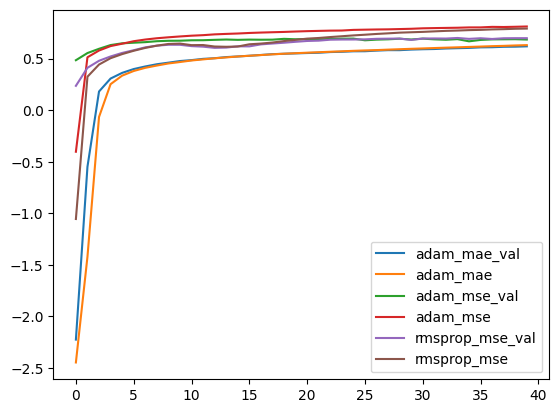

In [ ]:
plt.plot(adam_mae_model_h.history['val_r2_score'], label='adam_mae_val')
plt.plot(adam_mae_model_h.history['r2_score'], label='adam_mae')
plt.plot(adam_mse_model_h.history['val_r2_score'], label='adam_mse_val')
plt.plot(adam_mse_model_h.history['r2_score'], label='adam_mse')
plt.plot(rmsprop_mse_model_h.history['val_r2_score'], label='rmsprop_mse_val')
plt.plot(rmsprop_mse_model_h.history['r2_score'], label='rmsprop_mse')
plt.legend()
plt.show()

In [ ]:
plt.bar('rmsprop_mse_model', r2_score(y_test, rmsprop_mse_model.predict(X_test_sc)))
plt.bar('adam_mse_model', r2_score(y_test, adam_mse_model.predict(X_test_sc)))
plt.bar('adam_mae_model', r2_score(y_test, adam_mae_model.predict(X_test_sc)))
plt.bar('sgd_mse_model', r2_score(y_test, sgd_mse_model.predict(X_test_sc)))

NameError: name 'r2_score' is not defined

лучшей моделью оказалась последняя с оптимизатором rmsprop и функцией потерь mse